# Recommendation Systems

## 1. Introduction and Data

In this lab we are going to take a look at one of the <a href="http://grouplens.org/datasets/movielens/">MovieLens</a> data sets, more precisely the smallest one (<a href="http://files.grouplens.org/datasets/movielens/ml-100k.zip">ml-100k.zip</a>). Our data set includes 100,000 ratings of ~1.700 movies from ~1.000 users.

We start by reading the data into a <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html">Pandas data frame</a>. This allows us to asses the quality of the data set and gain first insights. Once we have established a fundamental understanding we proceed by building a simple recommendation system for movies.

In [1]:
import os

data_path = '.' + os.sep + 'ml-100k'

The files we have got the following documentation. Note that we are just using 'u.data' and 'u.item', while throwing away some meta data.

<i>
<hr />
u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC <br />

u.info     -- The number of users, items, and ratings in the u data set. <br />

u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set. <br />

u.genre    -- A list of the genres. <br />

u.user     -- Demographic information about the users; this is a tab <br />
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.
</i>
<hr />

So let's read our data.

In [2]:
import pandas as pd


movies = pd.read_csv(os.path.join(data_path, 'u.item'),
                     index_col=0,
                     sep='|', 
                     header=None, 
                     usecols=[0,1,2],
                     names=['movie_id', 'name', 'release_year'])
movies['release_year'] = movies['release_year'].apply(lambda s: None if pd.isnull(s) else int(s.split('-')[2]))

ratings = pd.read_csv(os.path.join(data_path, 'u.data'), 
                      sep='\t',
                      header=None,
                      usecols=[0,1,2],
                      names=['movie_id', 'user_id', 'rating'])
ratings = ratings.merge(movies, 'left', left_on='movie_id', right_index=True)

print("{} data points were loaded.".format(len(ratings)))

100000 data points were loaded.


Pandas' data frames can sliced like Python's lists. For instance, to obtain the first 10 entries of a data frame df it can be written df[0:10] or df.head(10). Pandas supports basic descriptive statistics via the 'describe' method.

In [3]:
print ratings.head(10)
print ratings.describe().rating[1:]

   movie_id  user_id  rating  \
0       196      242       3   
1       186      302       3   
2        22      377       1   
3       244       51       2   
4       166      346       1   
5       298      474       4   
6       115      265       2   
7       253      465       5   
8       305      451       3   
9         6       86       3   

                                                name  release_year  
0                          Dead Poets Society (1989)        1989.0  
1                         Blues Brothers, The (1980)        1980.0  
2                                  Braveheart (1995)        1996.0  
3                      Smilla's Sense of Snow (1997)        1997.0  
4     Manon of the Spring (Manon des sources) (1986)        1986.0  
5                                    Face/Off (1997)        1997.0  
6    Haunted World of Edward D. Wood Jr., The (1995)        1996.0  
7                            Pillow Book, The (1995)        1997.0  
8                         

Also advanced methods of selection are available. The following method gives an example of selecting all pairs of movies and ratings a specific user has done.

In [4]:
def rated_movies_by_user(user_id):
    return ratings[ratings['user_id'] == user_id][['movie_id', 'name', 'rating']]
    
print rated_movies_by_user(242)[:10]

      movie_id                                         name  rating
0          196                    Dead Poets Society (1989)       3
253         63                     Santa Clause, The (1994)       3
629        226                            Die Hard 2 (1990)       5
1232       154          Monty Python's Life of Brian (1979)       3
2159       306  Mrs. Brown (Her Majesty, Mrs. Brown) (1997)       5
2335       296                          Promesse, La (1996)       4
2600        34                  Doom Generation, The (1995)       5
3484       271                     Starship Troopers (1997)       4
4082       201                          Evil Dead II (1987)       4
5548       209                    This Is Spinal Tap (1984)       4


Pandas supports some plotting capabilities out of the box (that, for instance, uses matplotlib).

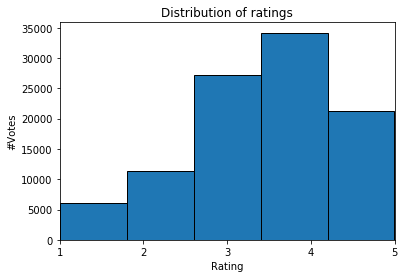

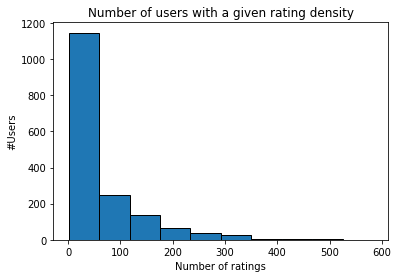

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

ratings.hist(bins=5, grid=False, column='rating', ec='k')
plt.xlim(1, 5)
plt.xlabel('Rating')
plt.ylabel('#Votes')
plt.title('Distribution of ratings')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

ratings.groupby('user_id')['rating'].count().hist(grid=False, ec='k')
plt.xlabel('Number of ratings')
plt.ylabel('#Users')
plt.title('Number of users with a given rating density')
plt.show()

#### Exercise 1.1
How is the distribution of the movies' release dates? What is the implication for the recommendation system? Could this data set be used to engineer a recommender for "film classics"?

In [6]:
# Ex. 1.1


#### Exercise 1.2
Do the scoring behavior differ among users? Is this problematic for the recommendation system?

In [8]:
# Ex. 1.2

## 2. Training of a Recommender System

Given $n$ users, $m$ movies and ratings $y_i$ that user $u^i$ gave for movie $x^i$ for $i = 1,\dots,r$. For a given integer $k$, the number of latent factors, we want to find the user factor matrix $\Psi \in \mathbb{R}^{n \times k}$ and the movie factor matrix $\Phi \in \mathbb{R}^{k \times m}$, that minimize the expression:

$$ L(y, \Psi, \Phi) = \sum_{i \in [r]}{\mathcal{l}\left(y^i, \Psi_{u^i} \Phi_{x^i} \right)} + \lambda( \|\Psi\|_F^2 + \| \Phi \|_F^2), $$

where $\| \cdot \|_F$ denotes the <a href="https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm">Frobenius norm</a>.

Writing $\hat B = \Psi \cdot \Phi$ as our estimated rating matrix and using the squared loss, we can rewrite the loss function as:

$$ L(y, \Psi, \Phi) = \sum_{i \in [r]}{(y^i - \hat B_{u^i, x^i})^2} + \lambda \left(\|\Psi\|_F^2 + \|\Phi\|_F^2\right). $$

We solve this problem by optimizing $L(y, \Psi, \Phi)$ by fixing one of the factor matrices and optimize by the other via gradient descent.

The loss function can be vectorized by looking at the rating matrix $B$ (which contains the $y^i$ at row $u^i$ and column $x^i$, unknown entries are marked with the symbol '?'). If we assume that $c + ? = ?$ and $c \cdot ? = 0$ for all real $c$. The loss function equals:

$$ L(B, \Psi, \Phi) = \left\|B - \hat B\right\|_F^2 + \lambda \left(\|\Psi\|_F^2 + \|\Phi\|_F^2\right) $$

To avoid the extra algebra defined on the symbol '?' in most cases we replace the '?' with $0$ (assume the rating labels are nonzero!) and consider a 'weight matrix' $W$, with $W_{i,j}$ is the indicator function whether user $i$ has rated movie $j$. Henceforth,

$$ L(B, \Psi, \Phi) = \left\| W \circ (\tilde B - \hat B) \right\|_F^2 + \lambda \left(\|\Psi\|_F^2 + \|\Phi\|_F^2\right), $$ 

where $\circ$ is the Hadamard or Schur product, defined as $(A \circ B)_{i, j} = A_{i, j} + B_{i, j}$ for any two matrices $A$ and $B$ of identical shape. Note that most practical implementations of sparse matrices assume that the values not set are zero, which is an important detail for the implementation of recommendation systems, where $B$ is usually a huge yet sparse matrix.

<hr />
Before we work on the movielens data set we are going through a simple example to make sure things are clear. Our goal is to find $k = 2$ latent factors. We have three users (Alice, Bob, Charlie), who rated four movies (Matrix, Zombieland, Titanic, Schindler's List), resulting in the following matrix:

$$  B = \begin{pmatrix} 5 & 4 & 1 & ? \\ 4 & ? & 5 & 4 \\ 5 & 3 & ? & 4 \end{pmatrix}. $$

To make handling these matrices easier, we are replacing the unknown values with zeros (giving us $\tilde B$) and hold a 'weight matrix' $W \in \mathbb{R}^{n \times m}$ that has the same shape as the rating matrix and $W_{i, j}$ is set to the indicator function if there exists a rating by user $i$ of movie $j$.

$$ \begin{align} \tilde B = \begin{pmatrix} 5 & 4 & 1 & 0 \\ 4 & 0 & 5 & 4 \\ 5 & 3 & 0 & 4 \end{pmatrix}, 
&& W = \begin{pmatrix} 1 & 1 & 1 & 0 \\ 1 & 0 & 1 & 1 \\ 1 & 1 & 0 & 1 \end{pmatrix}. \end{align}$$

From now an we drop the tilde from $\tilde B$.

The implementation of the loss function without regularization can be done as follows:

In [10]:
import numpy as np

B = np.asarray(np.matrix('5 4 1 0; 4 0 5 4; 5 3 0 4'))
W = np.asarray(np.matrix('1 1 1 0; 1 0 1 1; 1 1 0 1'))

def frobenius(A):
    return np.linalg.norm(A, 'fro')

def schur(A, B):
    """
    Computes the Schur product of A and B.
    The * operator for numpy.ndarrays is precisely the Schur product.
    """
    return np.asarray(A) * np.asarray(B)

def loss(B_hat, B, W):
    return frobenius(schur(W, B - B_hat))**2 # A.base * B.base equals the Schur product of A and B.

print loss(B, B, W)
print loss(np.matrix('4 4 1 2; 4 0 5 4; 5 3 0 4'), B , W)

0.0
1.0


#### Exercise 2.1
Implement the loss function $$ L(B, \Psi, \Phi) = \left\| W \circ ( \Psi \cdot \Phi - B) \right\|_F^2 + \lambda \left(\|\Psi\|_F^2 + \|\Phi\|_F^2\right), $$ with and without regularization.

In [11]:
# Ex. 2.1

def loss(Psi, Phi, B, W):
    pass

def reg_loss(Psi, Phi, B, W, lambd=0.1):
    pass

The following code minimize the regularised loss function by the Alternating Least Squares method presented in the lecture. Compare with the lecture slides and try to understand the steps of the algorithm.

In [13]:
import time

def incremental_als(B, W, k, lambd=0.1, iterations=10, verbose=True):
    m_user, n_movies = B.shape
    Psi = np.random.rand(m_user, k) # latent user features
    Phi = np.random.rand(k, n_movies) # latent movie features

    losses = np.zeros(iterations)
    for n in range(iterations):
        t0 = time.time()
        
        # opt. for all user
        for u, Wu in enumerate(W):
            Psi[u] = np.linalg.solve(np.dot(Phi, np.dot(np.diag(Wu), Phi.T)) + lambd * np.eye(k),
                                   np.dot(Phi, np.dot(np.diag(Wu), B[u].T))).T
        
        # opt. for all movies
        for x, Wx in enumerate(W.T):
            Phi[:,x] = np.linalg.solve(np.dot(Psi.T, np.dot(np.diag(Wx), Psi)) + lambd * np.eye(k),
                                     np.dot(Psi.T, np.dot(np.diag(Wx), B[:, x])))
        
        losses[n] = frobenius(schur(W, B - Psi.dot(Phi)))**2
        
        if verbose:
            print('[round: {}, duration: {:6.2f} sec., loss: {:6.2f}]'.format(n, time.time() - t0, losses[n]))

    if verbose:
        plt.plot(losses, marker='s')
        plt.xlabel('Iteration Round')
        plt.ylabel('Squared Loss')
        
    return Psi, Phi

#### Exercise 2.2
Use the implementation of the incremental_als methode to approximate $\Psi$ and $\Phi$ with 2 latent features for our example matrices $B$ and $W$.

In [14]:
# Ex. 2.2


#### Exercise 2.3
We can now predict ratings for movies by calculating $\hat B = \Psi \cdot \Phi$. Would Alice like Schindler's list? 

In [16]:
# Ex. 2.3


## 3. Working on the MovieLens data

Lets get back to the MovieLens data. We will reduce the number of users so training time will only take a couple of seconds instead of minutes.

In [18]:
np.random.seed(0)
user_ids = ratings.user_id.unique()
drop_users = np.random.permutation(user_ids)[500:] # keep 500 users randomly
drop_index = ratings.index[ratings.user_id.apply(lambda idx: idx in drop_users).values]
ratings = ratings.drop(drop_index).reset_index(drop=True)

print 'Number of users: {}'.format(ratings.user_id.unique().shape[0])

Number of users: 500


#### Exercise 3.1
Put everything we did so far together. Construct the $B$ and $W$ matrix from the MovieLens data. The <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html">pandas.pivot_table</a> method can be helpful. Learn $\Psi$ and $\Phi$  with 50 latent features and $\lambda = 2.5$. Print out the top 10 rated movies for some users and compare with the predicted rating from the recommender.

In [19]:
# Ex. 3.1


 We still don't know whether we over or under fit the data and which $k$ and $\lambda$ would be best. The incremental_cv_als method is an extended which takes a training and a test set as input and additionally returns the training and test loss.

In [21]:
def incremental_cv_als((B_train, W_train), (B_test, W_test), k, lambd=0.1, iterations=10, verbose=True):
    m_user, n_movies = B_train.shape
    Psi = np.random.rand(m_user, k) # latent user features
    Phi = np.random.rand(k, n_movies) # latent movie features

    losses_train = np.zeros(iterations)
    losses_test = np.zeros(iterations)
    for n in range(iterations):
        t0 = time.time()
        
        # opt. for all user
        for u, Wu in enumerate(W_train):
            Psi[u] = np.linalg.solve(np.dot(Phi, np.dot(np.diag(Wu), Phi.T)) + lambd * np.eye(k),
                                   np.dot(Phi, np.dot(np.diag(Wu), B_train[u].T))).T
        
        # opt. for all movies
        for x, Wx in enumerate(W_train.T):
            Phi[:,x] = np.linalg.solve(np.dot(Psi.T, np.dot(np.diag(Wx), Psi)) + lambd * np.eye(k),
                                     np.dot(Psi.T, np.dot(np.diag(Wx), B_train[:, x])))
        
        losses_train[n] = frobenius(schur(W_train, B_train - Psi.dot(Phi)))**2
        losses_test[n] = frobenius(schur(W_test, B_test - Psi.dot(Phi)))**2
        
        if verbose:
            out_str = '[round: {}, duration: {:6.2f} sec., loss: {:6.2f}, test loss: {:6.2f}]'
            print(out_str.format(n, time.time() - t0, losses_train[n], losses_test[n]))

    if verbose:
        plt.plot(losses_train, marker='s', label='train')
        plt.plot(losses_test, marker='s', label='test')
        plt.xlabel('Iteration Round')
        plt.ylabel('Squared Loss')
        plt.legend(loc='best')
        
        return (Psi, Phi), (losses_train[-1], losses_test[-1])

#### Exercise 3.2 
Split the data in a training and test set by creating $B_{train}$ and $B_{test}$ matrix from $B$ in such a way that about 75% percent of the ratings from $B$ are in $B_{train}$ and the remaining 25% of the ratings are in $B_{test}$ . Also construct $W_{train}$ and $W_{test}$. Use the incremental_cv_als to search for good parameter $k$ and $\lambda$ which minimize the test loss and don't over fit on the training set.

In [22]:
# Ex. 3.2
